<a href="https://colab.research.google.com/github/nourhanOfTerra/CIFAR-10/blob/main/CIFAR10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CIFAR-10 Classification Model: Convolutional Neural Networks

##Mounting Google Drive
Run the following cell to mount your Google Drive after uploading the project folder to your drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/CIFAR-10')

Mounted at /content/drive


##Importing the necessary libraries
* Installing tensorflow version 2.7.0 to replace the originally installed tensorflow 2.8.0 for keras to be imported. 
* h5py is used for saving the model with the best validation results to the project folder to be able to access it again.

In [3]:
!pip3 install tensorflow==2.7.0
!pip3 install h5py

     |████████████████████████████████| 489.6 MB 24 kB/s 
     |████████████████████████████████| 463 kB 64.3 MB/s 
     |████████████████████████████████| 1.3 MB 49.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstalled tensorflow-2.8.0


###General Libraries
Importing the general libraries that are not specific to CNNs in particular including numpy, matplotlib and pandas. They are used for executing operations on the dataset both in array and dataframe formats and for visualization purposes. Seaborn is used for the visualization of the confusion matrix at the end, and the rest of the libraries are used for various calculations.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import random
from time import time

###Model Specific Libraris
The libraries imported in the next cell are specific to machine learning work. Scikit learn is used in vaious stages of the program, including data preprocessing and model evaluation. Tensorflow is the backbone of the model. Keras is used for constructing the model layer by layer using Tensorflow. It is also used for the early stopping and model check point functionalities.

In [5]:
import tensorflow as tf
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import load_model

##Importing the data from csv files to variables
Note that since we are applying CNNs here, no need for feature extraction. Therefore, we should use the original features as they are. The next cell is importing the data features and labels that were previously saved in csv format to pandas dataframes.

In [11]:
df_features = pd.read_csv('features.csv')
df_labels = pd.read_csv('labels.csv')

Now converting to numpy arrays as they are easier to deal with in the upcoming functions of the scikit-learn library.

In [12]:
features = df_features.to_numpy()
labels = df_labels.to_numpy()

##Normalizing the features
Normalizing the data features to be all within the range [0, 1] to make the training process faster and to decrese the chances of getting stuck in local minima. This would also be useful for the activation functions. 

In [13]:
scaler = preprocessing.MinMaxScaler()
normalized_features = scaler.fit_transform(features)

##Encoding the labels using one-hot encoding
The reason for that is that there is no real relation between the integer values in the original labels vector and the labels.If the original encoding is used, where the label is an integer between [0, 9], the model might think that there is some kind of order implied by these numbers. This might be misleading for the model. One hot encoding might be better in this case. 

In [14]:
encoder = OneHotEncoder(sparse = False)
encoded_labels = encoder.fit_transform(labels)

##Reshaping the feature matrix for Tensorflow
Originally, the featurs were in the form of a 60000x3072 matrix, where each row is the representation of one image. The values corresponding to the red color component is represented in the first 1024 values, followed by 1024 for the green color component, and 1024 for the blue color component. In tensorflow, the conventional shape of entering the data is a 3 dimensional matrix in the form (number of images, image width, image height, 3) for RGB images. In my case it would be (60000, 32, 32, 3). To acheive this shape, the features matrix is reshaped to (60000, 3, 32, 32) then transposed to be in the form (60000, 32, 32, 3).

In [20]:
reshaped_features = np.reshape(normalized_features, (60000, 3, 32, 32))
transposed_features = reshaped_features.transpose(0, 2, 3, 1)

##Ensuring results reproducibility
The next cell was supposed to be used for ensuring the reproducibility of the results by setting the seed for all random operations to a predetermined number. I have decided not to use this cell as I do not really understand all the operations included, but decided to keep it in here for future investigation.

In [68]:
#os.environ['TF_DETERMINISTIC_OPS'] = '1'
#SEED = 20
#os.environ['PYTHONHASHSEED'] = str(SEED)
#random.seed(SEED)
#np.random.seed(SEED)
#tf.random.set_seed(SEED)

##Setting the parameters
The next cell is used for setting all the parameters of the model. It has been proved to be much easier to group all the values that can be changed in one place to avoid the confusion and weird issues if the values are changed in the functions themselves as they could be changed in one place and forgotten in another. This way, to improve the model, I can test the effect of each parameter without worrying about the functions themselves in the other cells.

In [6]:
SIZE = 32                                                                       # Don't Change
BATCHES = 32
EPOCHS = 100
LEARNING_RATE = 0.001
ACTIVATION = 'relu'
FILTER = (2, 2)                                                                 # Don't Change
POOLING = (2, 2)                                                                # Don't Change
OPTIMIZER = 'adam'
LOSS = tf.keras.losses.CategoricalCrossentropy(from_logits = True)              
METRICS = ['accuracy']
TEST = 10000/60000                                                              # Don't Change
VALIDATION = 10000/50000                                                        # Don't Change
INPUT_SHAPE = (32, 32, 3)                                                       # Don't Change
OUTPUTS = 10                                                                    # Don't Change

##Dividing the dataset into training, validation and testing sets
Although the dataset originally was divided into a training and a testing portion when downloaded from the source, I have combined them all together in the CIFAR10_Data.ipynb file for better processing of the features and for better generalization as the training, validation and testing sets would be chosen randomly in the following cell.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(transposed_features, encoded_labels, test_size = TEST)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = VALIDATION)

##Building the model
The model is built using the Keras API that will act as an interface to tensorflow. The model layers are added sequentially starting with the convolutional and maxpooling layers then ending with the dense fully connected layers. The final model consists of 3 convolutional layers, 2 maxpooling layers, and 2 dense layers. The inputs are flattened before the first dense layers to transform them from 3-dimensional to be 1-dimensional. The final dense layer (the output layer) is set to have 10 outputs that correspond to the 10 classes that we have in the dataset.

###Convolutional and MaxPooling layers

In [29]:
model = models.Sequential()
model.add(layers.Conv2D(SIZE, FILTER, activation = ACTIVATION, input_shape = INPUT_SHAPE))         # First convolutional layer
model.add(layers.MaxPooling2D(POOLING))                                                            # First MaxPooling
model.add(layers.Conv2D(2*SIZE, FILTER, activation = ACTIVATION))                                  # Second convolutional layer
model.add(layers.MaxPooling2D(POOLING))                                                            # Second MaxPooling
model.add(layers.Conv2D(2*SIZE, FILTER, activation = ACTIVATION))                                  # Third convolutional layer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 31, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          16448     
                                                                 
Total params: 25,120
Trainable params: 25,120
Non-traina

###Dense layers

In [30]:
model.add(layers.Flatten())                                 # Flattening because input to this layer is 3D Tensor
model.add(layers.Dense(2*SIZE, activation = ACTIVATION))    
model.add(layers.Dense(OUTPUTS))                            # Output layer (10 outputs for 10 classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 31, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          16448     
                                                                 
 flatten (Flatten)           (None, 2304)              0

##Early stopping and model checkpoint callback functions
Early stopping callback function will be used for stopping the training process once there is no change detected in the validation accuracy for a certain number of epochs (patience = 10 epochs). This will allow more freedom in setting a large number of epochs initially while ensuring that no overfitting occurs. 

The model checkpoint callback function will be used for saving the current configurations of the model each epoch where the validation accuracy improves. This will go hand in hand with early stopping to save the best model and also ensure that no overfitting occurs.

In [31]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 10, verbose = 1, min_delta = 0.01)
check_point = ModelCheckpoint('best_cnn.h5', monitor = 'val_accuracy', mode = 'max', save_best_only = True, verbose = 1)
CALLBACKS = [early_stopping, check_point]

##Training and validation

In [32]:
model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)
fitted_model = model.fit(X_train, y_train, batch_size = BATCHES, epochs = EPOCHS, validation_data = (X_val, y_val), callbacks = CALLBACKS)

Epoch 1/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.5022 - accuracy: 0.4585
Epoch 00001: val_accuracy improved from -inf to 0.56290, saving model to best_cnn.h5
1250/1250 [==============================] - 37s 29ms/step - loss: 1.5018 - accuracy: 0.4586 - val_loss: 1.2313 - val_accuracy: 0.5629
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 1.1257 - accuracy: 0.6034
Epoch 00002: val_accuracy improved from 0.56290 to 0.64610, saving model to best_cnn.h5
1250/1250 [==============================] - 41s 33ms/step - loss: 1.1257 - accuracy: 0.6034 - val_loss: 1.0191 - val_accuracy: 0.6461
Epoch 3/100
1249/1250 [============================>.] - ETA: 0s - loss: 0.9768 - accuracy: 0.6547
Epoch 00003: val_accuracy improved from 0.64610 to 0.65670, saving model to best_cnn.h5
1250/1250 [==============================] - 36s 29ms/step - loss: 0.9767 - accuracy: 0.6547 - val_loss: 0.9724 - val_accuracy: 0.6567
Epoch 4/100
1249/1250 [==============

##Plotting the training and validation accuracies against the number of epochs
This is used for tracking the progress of the trained model visually.

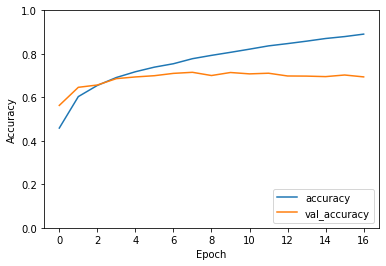

In [33]:
plt.plot(fitted_model.history['accuracy'], label = 'accuracy')
plt.plot(fitted_model.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.savefig('Accuracy vs Epochs Trial 7 activation = softmax at the end')

##Evaluation of the model on the testing set

##Loading the best model
Here the best saved model during the training process with the best improvement in validation accuracy.

In [40]:
best_model = load_model('best_cnn.h5')

##Testing
The tesing set is then used for evaluating the model performance on previously unseen data. The training accuracy is found to be averaged at 71.23%

In [41]:
test_loss, test_acc = best_model.evaluate(X_test,  y_test, verbose=3)
y_predicted = best_model.predict(X_test, batch_size = BATCHES, verbose = 1)
print('Test Accuracy:', test_acc)

313/313 [==============================] - 3s 10ms/step
Test Accuracy: 0.7123000025749207


The result of the previous evaluation is displayed using the upcoming cell. The confusion matrix is plotted using the seaborn library. As the cell in the plotted confusion matrix gets darker, the more images classified at this state. Best case scenario is to have the diagonal as the darkest blue, and white elsewhere. Other metrics used for the evaluation process are precision, recall, and f1 score. The weighted average of the precision is 0.71, weighted average of recall is 0.71, and the weighted average of the f1 score is also 0.71.


The confusion matrix: 
[[671  25  51  15  31  12   9  13 101  42]
 [ 17 839   5   8   5   4   9   8  24  98]
 [ 57   5 531  67 107  53  55  43  22  10]
 [  8   8  71 511  98 169  57  30  23  12]
 [ 22   1  51  48 739  24  31  53  14   7]
 [  5   1  42 177  76 607  31  60   5   8]
 [  4  10  45  63  70  27 774   5  13   9]
 [  9   5  25  41 121  42   3 747   8  13]
 [ 43  33  19  18  12   4   6   3 843  29]
 [ 21  80   3  11  10   6   4  14  20 861]] 



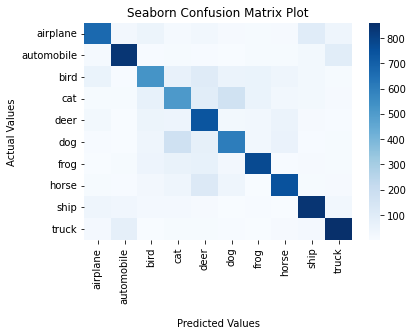


The classification report: 
              precision    recall  f1-score   support

           0       0.78      0.69      0.73       970
           1       0.83      0.82      0.83      1017
           2       0.63      0.56      0.59       950
           3       0.53      0.52      0.53       987
           4       0.58      0.75      0.65       990
           5       0.64      0.60      0.62      1012
           6       0.79      0.76      0.77      1020
           7       0.77      0.74      0.75      1014
           8       0.79      0.83      0.81      1010
           9       0.79      0.84      0.81      1030

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000


Test Accuracy: 0.7123


In [42]:
confused = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_predicted, axis = 1))
print("\nThe confusion matrix: ")
print(confused, '\n')
my_map = sns.heatmap(confused, cmap = 'Blues')
my_map.set_title('Seaborn Confusion Matrix Plot')
my_map.set_xlabel('\nPredicted Values')
my_map.set_ylabel('Actual Values')
my_map.xaxis.set_ticklabels(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
plt.xticks(rotation = 90)
my_map.yaxis.set_ticklabels(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
plt.yticks(rotation = 0)
plt.show()
report = classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predicted, axis = 1))
print("\nThe classification report: ")
print(report)
acc_score = accuracy_score(np.argmax(y_test, axis = 1), np.argmax(y_predicted, axis = 1))
print("\nTest Accuracy:", acc_score)

##Resources

Source 1: https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c

Source 2: https://www.tensorflow.org/tutorials/images/cnn

Source 3: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

Source 4: https://neptune.ai/blog/keras-metrics

Source 5: https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b
